In [2]:
%matplotlib inline

In [3]:
from clpsych.store import Store
from clpsych.data import *
from collections import Counter

import pandas as pd
import codecs
import os

In [4]:
pvs = []
i = 0
while os.path.isfile('data/parses/{}.parse'.format(i)):
    if i % 10 == 0: print i
    # load all the parses
    docs, titles = read_parses('data/parses/{}.parse'.format(i))
    # get all the passive voice
    keys = [key for key in docs.keys() if key]
    for key in keys:
        pv = []
        for token in docs[key]:
            if token.dep == 'nsubjpass':
                pv.append(token.dep + ':' + token.lemma)
        for token in titles[key]:
            if token.dep == 'nsubjpass':
                pv.append(token.dep + ':' + token.lemma)
        pvs.append((key, pv))
    i += 1
pvs = pd.DataFrame(pvs, columns=['post_id', 'passives'])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210


In [5]:
train_classes = pd.DataFrame.from_csv('data/classes/train_classes.txt')
dev_classes = pd.DataFrame.from_csv('data/classes/dev_classes.txt')
sample_classes = pd.DataFrame.from_csv('data/classes/sample_classes.txt')

In [6]:
train_pvs = pvs.merge(train_classes, on='post_id')
test_pvs = pvs.merge(dev_classes, on='post_id')

In [7]:
positives = [p for ps in train_pvs[train_pvs['class'] == True]['passives'].tolist() for p in ps]
controls = [p for ps in train_pvs[train_pvs['class'] == False]['passives'].tolist() for p in ps]

In [8]:
pos_cnt = Counter(positives)
#pos_cnt = {k: v for k, v in pos_cnt.items() if v > 20}

In [9]:
all_cnt = Counter(positives + controls)
all_cnt = {k: v for k, v in all_cnt.items() if v > 20}

In [10]:
pos_total = sum([v for k, v in pos_cnt.items()])
all_total = sum([v for k, v in all_cnt.items()])

In [13]:
pos_cnt = Counter({k: 1.*v/pos_total for k, v in pos_cnt.items()})
all_cnt = {k: 1.*v/all_total for k, v in all_cnt.items()}

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

vect = CountVectorizer(tokenizer=lambda x: x, lowercase=False, vocabulary=[pv[0] for pv in pos_cnt.most_common(25)])
X_train = vect.fit_transform(train_pvs['passives'])
X_test = vect.transform(test_pvs['passives'])

# svd = TruncatedSVD(n_components=10)
# X_train = svd.fit_transform(X_train)
# X_test = svd.transform(X_test)

y_train = train_pvs['class'].as_matrix()
y_test = test_pvs['class'].as_matrix()

Accuracy: 0.728855914899
AUC: 0.513130429477
F1 Score: 0.843154129122


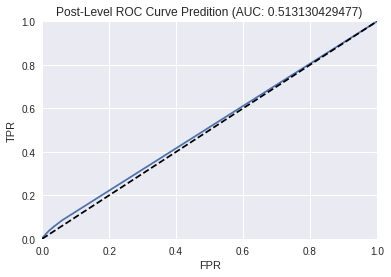

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

labels = clf.predict_proba(X_test)

print 'Accuracy:', accuracy_score(y_test, np.argmax(labels, axis=1))

fpr, tpr, thresholds = roc_curve(y_test, labels[:, 1])

plt.plot(fpr, tpr)
plt.title('Post-Level ROC Curve Predition (AUC: {})'.format(roc_auc_score(y_test, labels[:, 1])))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.savefig('passive_voice_uninformative.png')

print 'AUC:', roc_auc_score(y_test, labels[:, 1])
print 'F1 Score:', f1_score(y_test, np.argmax(labels, axis=1))